#**Language Model: Reflex and RouterReflexAttention for long term memory for sequences**
S. Vysotsky, Central University




*abstract:*
___
The problem of representation collapse and over-squashing in the later layers (as discussed in the paper “Transformers need glasses! Information over-squashing in language tasks”, 1) negatively impacts the accuracy of large language models when solving tasks that require considering long-term context.

Decoder layers in language models are trained to predict the next tokens. However, the model loses direct access to early representations (residual) when performing self-attention.

The idea of providing the model with a high degree of freedom in choosing the decisive features for prediction is one of the key ideas in improving its quality in deep learning. After all, why should we decide for the model which features it should focus on at any given moment during the forward pass, if it can do it itself without our help? Neural networks and backpropagation allow such representations to be learned. Routers and weight combinations are capable of describing the importance of each representation to the model (weighted sum). This motivation leads to the intuition of adding weighted combinations of hidden states from all layers of the decoder-transformer when building the attention matrix at each new layer. We will call this technique Reflex Router Attention ($\sim$ CA vs SA). This learnable router gives the model the freedom to choose which hidden state to reuse. The motivation for this idea is borrowed from the paper “Hyper-Connections” (2). Hyper-connections provide freedom and flexibility for the model both between layers and within a single layer. We use this motivation to address the problems of collapse and over-squashing of late-stage hidden representations in the final layers (by adding knowledge from earlier layers).


notation:

Self-Attention SA

Cross-Attention CA



*reference:*

*(1)  Transformers need glasses! |
Information over-squashing in language tasks, 2024*
https://arxiv.org/pdf/2406.04267

*(2) Hyper-Connections, 2024*
https://arxiv.org/pdf/2409.19606

*code and data from A.Karpathy repo on GitHub*:
https://github.com/karpathy/nanoGPT


---

*work:*

*Continuing the work, the main experiments are presented here below.*

train loss:

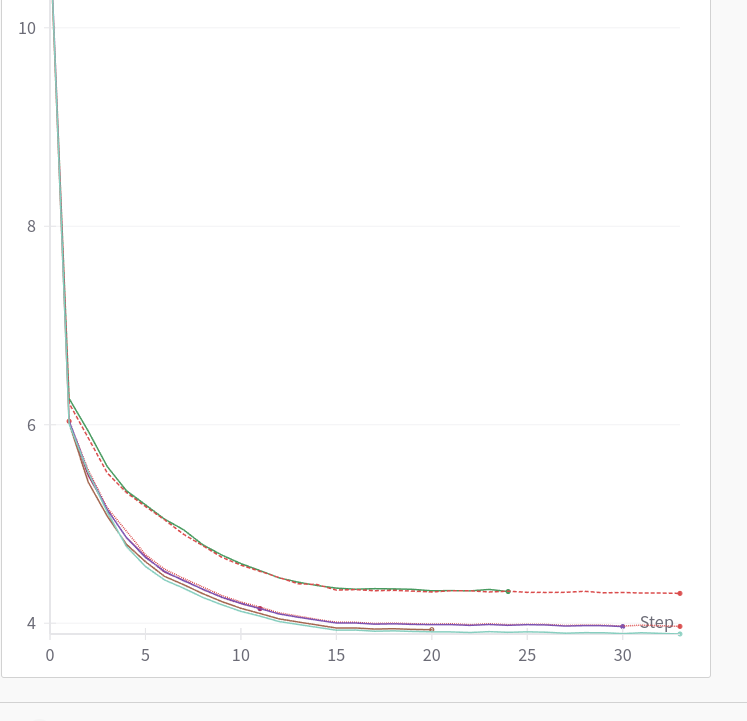

val loss

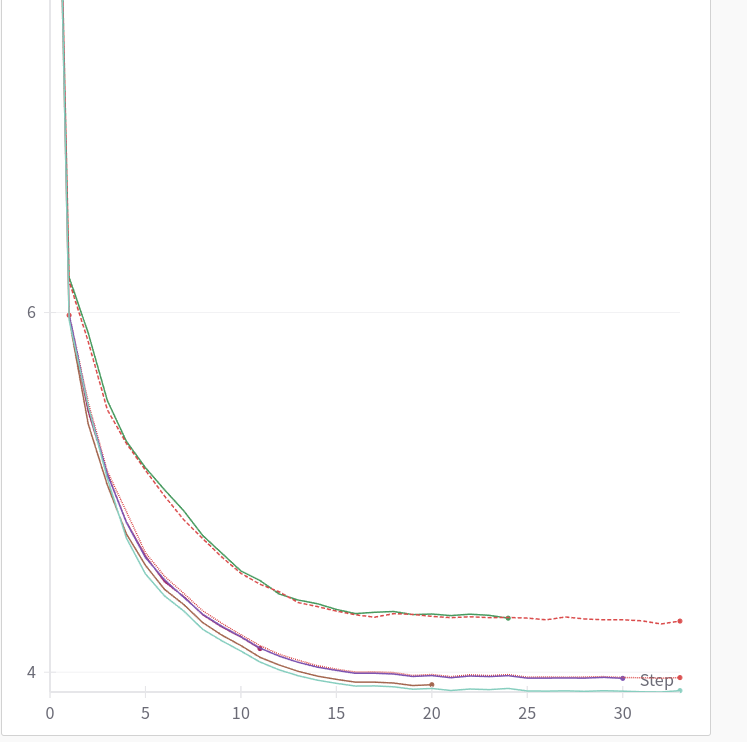

“By decreasing loss”

3.Reflex Router Attention on s_d_p CA for all hidden states (first 2 layer SA)

2.Redlex Router Attention on all hidden states (linear combinations for future s_d_p) (first 2 layer SA)

1.Reflex Attention (const) 6head=cat(CA(prev1), CA(prev2), SA) (first 2 layer SA) and also simple Transformer

---

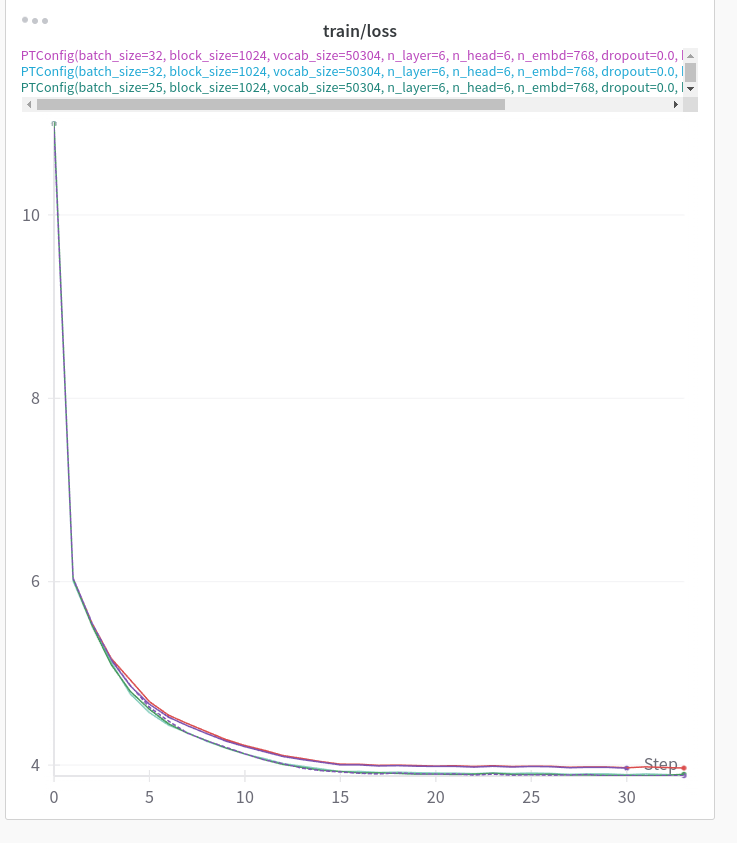

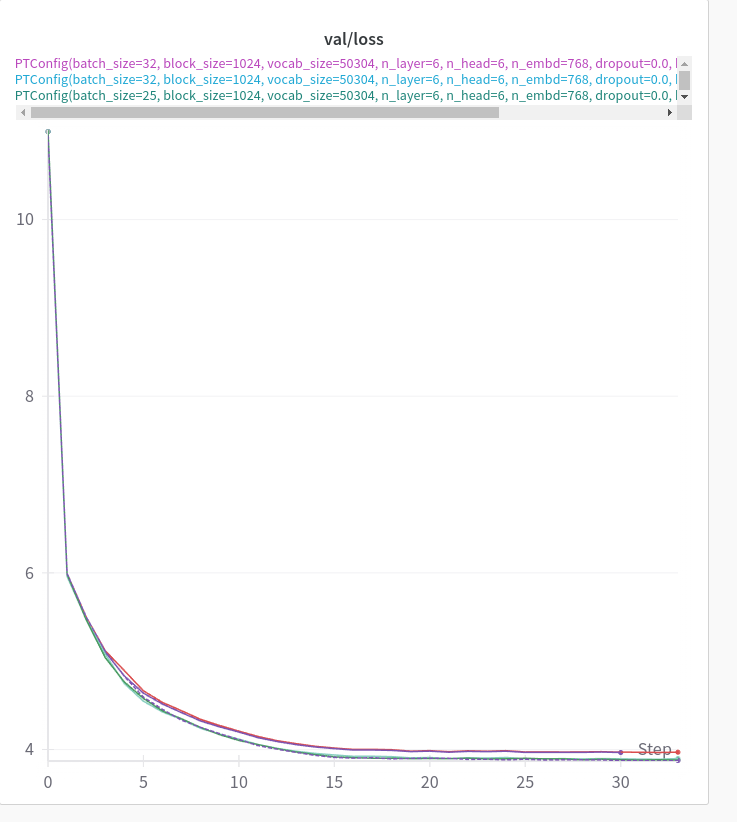

Эти графики лосса описывают эксперимент по сравнению трех концепций моделей: Simple Transformer(6head, 6layers, all SA) and Reflex Attention(в двух конфигурациях). Качество стандартного SA показывает результат лучше, однако конфигурация похожая на стандартный SA (добавить две головы CA на два последних скрытых состояния) дает аналогичный результат. При росте модели модель способна учитывать зависимости с прошлых слоев лучше, в том числе учитывать прошлые скрытые состояния и предсказания в них (длинный контекст).


---

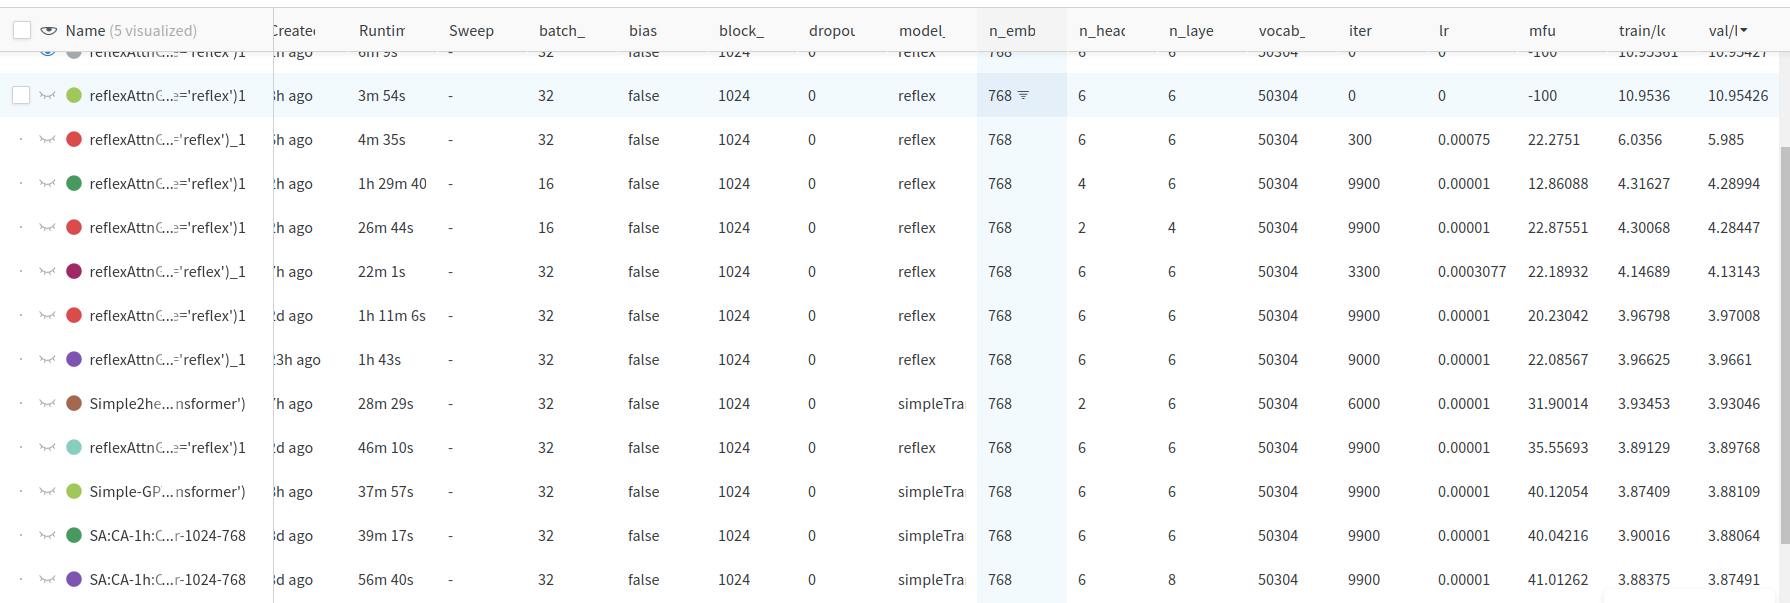

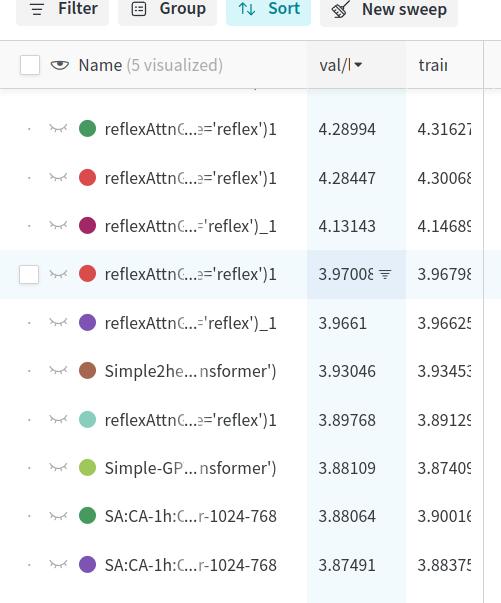

“By decreasing loss”

3.Reflex Router Attention on s_d_p CA for all hidden states (first 2 layer SA)

2.Redlex Router Attention on all hidden states (linear combinations for future s_d_p) (first 2 layer SA)

1.Reflex Attention (const) 6head=cat(CA(prev1), CA(prev2), SA) (first 2 layer SA) and also simple Transformer

Подводя итог: RA может как увеличить, так и у ухудшить скор модели. Так, закрепленный вариант с Reflex Attention (без роутера) на эмпирический опыте показал результат лучше, чем эксперимент с его улучшенной версией и большей степенью свободы в виде Router Reflex Attention. Необходимо провести больше экспериментов, а так посмотреть на влияние таких факторов как изменение конфигураций моделей, тюнинг весов, добавление сдвигов в пользу более дальних/ближних скрытых представлений в RA.  Также стоит исследовать тему перенасыщение информацией у модели такого вида: так, на эксперименте два можно было заметить, что когда мы лишаем модель степени свободы качество возрастает на некоторый сдвиг. Возможно, это связано с перемешиванием информации и может негативно сказаться на моделях похожих гипер-связей. Что касается масштабирования, модели большой глубины с RA показывают лучший скор по сравнению с похожим меньшего размера. Можно предположить, что увелечение модели (в т.ч. добавление преобладающего числа SA simple голов) улучшит ее показания и с точки зрения учитывания длинного контекста.

##preparing (data, modules)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prepared data from karpathy rep< please check prepare.py from karpathy repo -> (train.bin, val.bin)
# data.zip: train https://drive.google.com/file/d/1gx2iQux-hNQ6Gq1a1XwrJigevgkrTyr1/view?usp=drive_link
#           val: https://drive.google.com/file/d/1YZ4mzkLdy6UCfpYbJABgT7ymhflFkdoA/view?usp=drive_link
!unzip '/content/drive/MyDrive/val.bin.zip' -d '/content'
!unzip '/content/drive/MyDrive/train.bin.zip' -d '/content'

Archive:  /content/drive/MyDrive/val.bin.zip
  inflating: /content/val.bin        
Archive:  /content/drive/MyDrive/train.bin.zip
  inflating: /content/train.bin      


In [ ]:
!git clone https://github.com/karpathy/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 682, done.
remote: Total 682 (delta 0), reused 0 (delta 0), pack-reused 682 (from 1)
Receiving objects: 100% (682/682), 952.47 KiB | 6.80 MiB/s, done.
Resolving deltas: 100% (385/385), done.


In [ ]:
!pip install torch tqdm matplotlib wandb tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np

import inspect
from dataclasses import dataclass
import os
from tqdm import tqdm
import time

import tiktoken
import pickle

from contextlib import nullcontext

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## GPT: Self-Attention (6 layer, 6 head) (1)

In [ ]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, prevs):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        if self.model_type == 'simpleTransformer': # len(prevs) == 0):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = SelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, prevs):
        attn_kv = self.attn(self.ln1(x), prevs)
        x = x + res_kv[0]
        x = x + self.mlp(self.ln2(x))
        return x, attn_kv[1]

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        prevs = []

        #attention
        for i, block in enumerate(self.transformer.h):
            x = block(x)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'simpleTransformer' # or 'reflex'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='simpleTransformer')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'SA:{config}'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
out_dir = '/content/SimpleGPT'


In [ ]:
eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1
learning_rate = 1e-3
max_iters = 10000

In [ ]:
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 13, with 9,984 parameters
using fused AdamW: True


<ipython-input-22-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-6-0fa6fba77f89> line 178 
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125] due to: 
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1123 23:49:12.268000 1227 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torc

step 0: train loss 11.0130, val loss 11.0141
iter 0: loss 11.0115, time 27989.16ms, mfu -100.00%
iter 10: loss 9.7645, time 141.54ms, mfu 40.31%
iter 20: loss 9.2972, time 141.08ms, mfu 40.33%
iter 30: loss 8.7169, time 141.23ms, mfu 40.33%
iter 40: loss 8.0334, time 141.18ms, mfu 40.34%
iter 50: loss 7.5373, time 141.25ms, mfu 40.35%
iter 60: loss 7.2411, time 141.04ms, mfu 40.36%
iter 70: loss 7.0573, time 141.59ms, mfu 40.35%
iter 80: loss 6.9193, time 141.89ms, mfu 40.34%
iter 90: loss 6.7982, time 141.65ms, mfu 40.33%
iter 100: loss 6.5973, time 141.06ms, mfu 40.34%
iter 110: loss 6.6217, time 141.01ms, mfu 40.36%
iter 120: loss 6.4570, time 141.09ms, mfu 40.37%
iter 130: loss 6.4833, time 141.36ms, mfu 40.37%
iter 140: loss 6.3151, time 141.55ms, mfu 40.36%
iter 150: loss 6.3043, time 141.16ms, mfu 40.37%
iter 160: loss 6.2880, time 141.20ms, mfu 40.37%
iter 170: loss 6.2788, time 141.81ms, mfu 40.36%
iter 180: loss 6.2460, time 141.22ms, mfu 40.36%
iter 190: loss 6.3344, time 14

In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


iter,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▁▆███▇▇▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mfu,▁█████████████████████████████████
train/loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iter,9900
lr,1e-05
mfu,40.04216
train/loss,3.90016
val/loss,3.88064


step 0: train loss 10.9497, val loss 10.9499
iter 0: loss 10.9504, time 24529.40ms, mfu -100.00%
iter 10: loss 9.6326, time 163.59ms, mfu 41.54%
iter 20: loss 9.2106, time 163.59ms, mfu 41.54%
iter 30: loss 8.5639, time 164.18ms, mfu 41.53%
iter 40: loss 8.0578, time 164.49ms, mfu 41.51%
iter 50: loss 7.3758, time 163.44ms, mfu 41.52%
iter 60: loss 7.2529, time 163.71ms, mfu 41.52%
iter 70: loss 7.2918, time 163.93ms, mfu 41.51%
iter 80: loss 7.0256, time 164.93ms, mfu 41.48%
iter 90: loss 6.8288, time 164.12ms, mfu 41.47%
iter 100: loss 6.7967, time 163.78ms, mfu 41.48%
iter 110: loss 6.5470, time 164.88ms, mfu 41.45%
iter 120: loss 6.5472, time 163.97ms, mfu 41.45%
iter 130: loss 6.4576, time 165.01ms, mfu 41.42%
iter 140: loss 6.4775, time 163.89ms, mfu 41.43%
iter 150: loss 6.3820, time 164.79ms, mfu 41.41%
iter 160: loss 6.4546, time 163.87ms, mfu 41.42%
iter 170: loss 6.2390, time 164.58ms, mfu 41.40%
iter 180: loss 6.4073, time 164.10ms, mfu 41.41%
iter 190: loss 6.1933, time 16

## GPT: Reflex-Attention: (2)

**1-6 layer: 2head: SA, 2head: CA(h of prev layer), 2head: CA(h of prev2x layer)**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)

class ReflexAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # fullSA for all 6heads:
        # splitting embeds for 6heads

        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        if self.model_type == 'reflex' and hidden_states.__len__() < 2:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            # reflex_attention 6heads from
            k_prevx, v_prevx = hidden_states[1]
            k_prevxx, v_prevxx = hidden_states[0]

            #SA_i=SA(k_i, v_i, q_i) for 2head
            q_i, k_i, v_i = q[:, :2, :, :], k[:, :2, :, :], v[:, :2, :, :]
            SA_i = torch.nn.functional.scaled_dot_product_attention(q_i, k_i, v_i,
                                                                    attn_mask=None,
                                                                    dropout_p=self.dropout if self.training else 0,
                                                                    is_causal=True)
            #SA_i=SA(k_i, v_i, q_i) for 2head

            q_i_for_prevx_head, k_prevx_head, v_prevx_head = q[:, 2:4, :, :], k_prevx[:, 2:4, :, :], v_prevx[:, 2:4, :, :]
            CA_ix = torch.nn.functional.scaled_dot_product_attention(q_i_for_prevx_head, k_prevx_head, v_prevx_head,
                                                                                attn_mask=None,
                                                                                dropout_p=self.dropout if self.training else 0,
                                                                                is_causal=True)
            # 2 head for previous previous layer

            q_i_for_prevxx_head, k_prevxx_head, v_prevxx_head = q[:, 4:, :, :], k_prevxx[:, 4:, :, :], v_prevxx[:, 4:, :, :]
            CA_ixx = torch.nn.functional.scaled_dot_product_attention(q_i_for_prevxx_head, k_prevxx_head, v_prevxx_head,
                                                                                attn_mask=None,
                                                                                dropout_p=self.dropout if self.training else 0,
                                                                                is_causal=True)
            # concatenate: Attn_i= Cat[SA_i, CA_i_i-1, CA_i_i-2]
            y = torch.cat([SA_i, CA_ix, CA_ixx], dim=1)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)
            # level1
            if self.config.model_type == 'reflex':
                if i >= 2:
                  hidden_states.pop(0)
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT={config}1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 13, with 9,984 parameters
using fused AdamW: True


<ipython-input-37-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-28-ff320e365d7f> line 163 
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125] due to: 
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/__ini

step 0: train loss 10.9687, val loss 10.9696
iter 0: loss 10.9723, time 27964.86ms, mfu -100.00%
iter 10: loss 9.7752, time 158.71ms, mfu 35.95%
iter 20: loss 9.2403, time 159.47ms, mfu 35.94%
iter 30: loss 8.7068, time 160.25ms, mfu 35.90%
iter 40: loss 8.0201, time 159.29ms, mfu 35.89%
iter 50: loss 7.3922, time 158.90ms, mfu 35.90%
iter 60: loss 7.2296, time 158.03ms, mfu 35.92%
iter 70: loss 7.0705, time 158.37ms, mfu 35.93%
iter 80: loss 7.1468, time 158.76ms, mfu 35.93%
iter 90: loss 6.7766, time 159.08ms, mfu 35.92%
iter 100: loss 6.7940, time 159.37ms, mfu 35.91%
iter 110: loss 6.6914, time 158.85ms, mfu 35.91%
iter 120: loss 6.5497, time 159.08ms, mfu 35.91%
iter 130: loss 6.3929, time 158.87ms, mfu 35.91%
iter 140: loss 6.3806, time 158.94ms, mfu 35.91%
iter 150: loss 6.3009, time 159.19ms, mfu 35.90%
iter 160: loss 6.4253, time 159.20ms, mfu 35.90%
iter 170: loss 6.3922, time 158.84ms, mfu 35.90%
iter 180: loss 6.1838, time 158.98ms, mfu 35.90%
iter 190: loss 6.2093, time 15

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-49-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow.

One of the last few months we've been so lucky to have it. We're very lucky to have it on a ship that's still an island, so I had to live there long enough.

But for the sake of life I'm not sure it will happen. I know I'm going to visit my husband, and he's a great friend, but I'll have to wait for him to leave.

I've been so lucky to have it on a ship that we all went to visit our ship. I've met my father for the last few days. He's the husband of a man who is an active member of the ship and has been there since my age. I'm not sure what I'm going to tell.

This is the second mission I've met. That is what the sea has been. The last, part of the sea has been there in the past year, but it's actually one of the most important missions to come.

For a long time I've just met my father and raised my heart. He never was there.

In the last few months, for a long time, the captain has told me what he has done. He has been here since the morning of the day when we have had it.

In [ ]:
start = "How to join a tbank-research?"
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

How to join a tbank-research?

Yes, that is. It is. It is. It is. It is. Since the beginning of the late 20th century the world is a far more distant future. But what we go is a great and we do it every day. We have a great time. We are a far more distant future. And we have a great time. We can’t wait for the next few years.

To talk about the future of the world is for a moment. And then a moment of uncertainty in the present, we know that there will be no sooner than tomorrow. We have an idea of why we are now all we need to know. We have a vision for the future. We have to be clear that we have a vision for the future. We have to be clear that we have a vision for the future. We have a vision for potential future. We have a vision for the future. We have an idea of the future. We have a vision for the future. We have a vision for the future. We have a vision for us. We have a vision for the future. We have a vision for the future. We have an vision for the future. We have nothing b

## GPT: Reflex-Attention (3)
**1-6 layer: 2head: SA, 2head: CA(h of prev layer), 2head: CA(h of prev2x layer)**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)

class ReflexAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # fullSA for all 6heads:
        # splitting embeds for 6heads

        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        if self.model_type == 'simple' or (self.model_type == 'reflex' and hidden_states.__len__() < 2):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            # reflex_attention 6heads from
            k_prevx, v_prevx = hidden_states[1]
            k_prevxx, v_prevxx = hidden_states[0]

            #SA_i=SA(k_i, v_i, q_i) for 2head
            q_i, k_i, v_i = q[:, :2, :, :], k[:, :2, :, :], v[:, :2, :, :]
            SA_i = torch.nn.functional.scaled_dot_product_attention(q_i, k_i, v_i,
                                                                    attn_mask=None,
                                                                    dropout_p=self.dropout if self.training else 0,
                                                                    is_causal=True)
            #SA_i=SA(k_i, v_i, q_i) for 2head

            q_i_for_prevx_head, k_prevx_head, v_prevx_head = q[:, 2:4, :, :], k_prevx[:, 2:4, :, :], v_prevx[:, 2:4, :, :]
            CA_ix = torch.nn.functional.scaled_dot_product_attention(q_i_for_prevx_head, k_prevx_head, v_prevx_head,
                                                                                attn_mask=None,
                                                                                dropout_p=self.dropout if self.training else 0,
                                                                                is_causal=True)
            # 2 head for previous previous layer

            q_i_for_prevxx_head, k_prevxx_head, v_prevxx_head = q[:, 4:, :, :], k_prevxx[:, 4:, :, :], v_prevxx[:, 4:, :, :]
            CA_ixx = torch.nn.functional.scaled_dot_product_attention(q_i_for_prevxx_head, k_prevxx_head, v_prevxx_head,
                                                                                attn_mask=None,
                                                                                dropout_p=self.dropout if self.training else 0,
                                                                                is_causal=True)
            # concatenate: Attn_i= Cat[SA_i, CA_i_i-1, CA_i_i-2]
            y = torch.cat([SA_i, CA_ix, CA_ixx], dim=1)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)

        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)

            # level1
            if self.config.model_type == 'reflex':
                if i >= 2:
                  hidden_states.pop(0)
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT={config}1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 13, with 9,984 parameters
using fused AdamW: True


<ipython-input-37-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-28-ff320e365d7f> line 163 
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125] due to: 
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1124 21:41:49.133000 190 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/__ini

step 0: train loss 10.9687, val loss 10.9696
iter 0: loss 10.9723, time 27964.86ms, mfu -100.00%
iter 10: loss 9.7752, time 158.71ms, mfu 35.95%
iter 20: loss 9.2403, time 159.47ms, mfu 35.94%
iter 30: loss 8.7068, time 160.25ms, mfu 35.90%
iter 40: loss 8.0201, time 159.29ms, mfu 35.89%
iter 50: loss 7.3922, time 158.90ms, mfu 35.90%
iter 60: loss 7.2296, time 158.03ms, mfu 35.92%
iter 70: loss 7.0705, time 158.37ms, mfu 35.93%
iter 80: loss 7.1468, time 158.76ms, mfu 35.93%
iter 90: loss 6.7766, time 159.08ms, mfu 35.92%
iter 100: loss 6.7940, time 159.37ms, mfu 35.91%
iter 110: loss 6.6914, time 158.85ms, mfu 35.91%
iter 120: loss 6.5497, time 159.08ms, mfu 35.91%
iter 130: loss 6.3929, time 158.87ms, mfu 35.91%
iter 140: loss 6.3806, time 158.94ms, mfu 35.91%
iter 150: loss 6.3009, time 159.19ms, mfu 35.90%
iter 160: loss 6.4253, time 159.20ms, mfu 35.90%
iter 170: loss 6.3922, time 158.84ms, mfu 35.90%
iter 180: loss 6.1838, time 158.98ms, mfu 35.90%
iter 190: loss 6.2093, time 15

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-49-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow.

One of the last few months we've been so lucky to have it. We're very lucky to have it on a ship that's still an island, so I had to live there long enough.

But for the sake of life I'm not sure it will happen. I know I'm going to visit my husband, and he's a great friend, but I'll have to wait for him to leave.

I've been so lucky to have it on a ship that we all went to visit our ship. I've met my father for the last few days. He's the husband of a man who is an active member of the ship and has been there since my age. I'm not sure what I'm going to tell.

This is the second mission I've met. That is what the sea has been. The last, part of the sea has been there in the past year, but it's actually one of the most important missions to come.

For a long time I've just met my father and raised my heart. He never was there.

In the last few months, for a long time, the captain has told me what he has done. He has been here since the morning of the day when we have had it.

In [ ]:
start = "How to join a tbank-research?"
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

How to join a tbank-research?

Yes, that is. It is. It is. It is. It is. Since the beginning of the late 20th century the world is a far more distant future. But what we go is a great and we do it every day. We have a great time. We are a far more distant future. And we have a great time. We can’t wait for the next few years.

To talk about the future of the world is for a moment. And then a moment of uncertainty in the present, we know that there will be no sooner than tomorrow. We have an idea of why we are now all we need to know. We have a vision for the future. We have to be clear that we have a vision for the future. We have to be clear that we have a vision for the future. We have a vision for potential future. We have a vision for the future. We have an idea of the future. We have a vision for the future. We have a vision for the future. We have a vision for us. We have a vision for the future. We have a vision for the future. We have an vision for the future. We have nothing b

## GPT: Reflex-Router-Attention (5)

**2 layer: SA for 6 head**

**3-6 layer: Reflex-Router-Attention for 6 head for all previous hidden states: fitting linear combination**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)


class Router(nn.Module):
  def __init__(self, n_head, i_layer):
    super().__init__()
    self.weights = nn.ParameterDict({str(i): nn.Parameter(torch.randn(i_layer)) for i in range(n_head)}) #.to(device) #cuda

  def forward(self, k_vs, head_i):
    return sum(weight * k_v for weight, k_v in zip(self.weights[str(head_i)], k_vs))


class ReflexRouterAttention(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.router = Router(config.n_head, i_layer + 1)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        #reflex!
        if self.model_type == 'simple' or (self.model_type == 'reflex' and hidden_states.__len__() < 3):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            attn = []
            for i in range(self.n_head):
              # for i's head
              q_i, k_i, v_i = q[:, i,:, :], self.router([hidden_state[0][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i), self.router([hidden_state[1][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i)
              attn.append(torch.nn.functional.scaled_dot_product_attention(q_i, k_i, v_i, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
              del q_i, k_i, v_i
            y = torch.cat(attn, dim=1)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexRouterAttention(config, i_layer)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, _) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)

            # level2: for router
            if self.config.model_type == 'reflex':
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT_with_router={config}1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 49, with 10,110 parameters
using fused AdamW: True


<ipython-input-20-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


wandb: Currently logged in as: 206spv (206spv-central-university). Use `wandb login --relogin` to force relogin


W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-11-0f0ed152afa8> line 153 
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125] due to: 
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1125 02:04:10.090000 6393 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/tor

step 0: train loss 10.9932, val loss 10.9934
iter 0: loss 10.9969, time 50475.59ms, mfu -100.00%
iter 10: loss 9.9123, time 280.19ms, mfu 20.36%
iter 20: loss 9.2266, time 280.14ms, mfu 20.36%
iter 30: loss 8.6969, time 280.29ms, mfu 20.36%
iter 40: loss 7.9985, time 279.70ms, mfu 20.37%
iter 50: loss 7.4439, time 280.25ms, mfu 20.37%
iter 60: loss 7.3035, time 281.11ms, mfu 20.36%
iter 70: loss 7.1692, time 280.56ms, mfu 20.36%
iter 80: loss 6.7882, time 279.97ms, mfu 20.36%
iter 90: loss 6.8603, time 280.23ms, mfu 20.36%
iter 100: loss 6.6895, time 280.95ms, mfu 20.36%
iter 110: loss 6.5602, time 280.57ms, mfu 20.35%
iter 120: loss 6.6441, time 280.26ms, mfu 20.35%
iter 130: loss 6.3946, time 280.04ms, mfu 20.36%
iter 140: loss 6.4340, time 281.01ms, mfu 20.35%
iter 150: loss 6.4244, time 280.88ms, mfu 20.35%
iter 160: loss 6.4920, time 279.73ms, mfu 20.35%
iter 170: loss 6.3158, time 279.98ms, mfu 20.36%
iter 180: loss 6.2929, time 281.51ms, mfu 20.35%
iter 190: loss 6.3015, time 28

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-23-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow. It's still the same," she said.

"And I want it to lose."<|endoftext|>The Army soldiers who went to work in Afghanistan have been arrested on the site, including the last one for two years for the Veterans Affairs of the Army.

By the time the Army will be charged, at least three thousand soldiers, the Defense Department says.

The Army has been involved since March 31, which includes the new "an" system for troops in Afghanistan, Afghanistan, the Pentagon's Secretary of Defense, and the military's top commander.

The more than 100 troops are expected to be in this year's first two years for the Pentagon and Lockheed Martin.

The Pentagon has the second largest collection of detainees, which includes the 10,000 prisoners convicted of crimes in Afghanistan and Afghanistan, according to the National Centers for National Guard, the Defense Department said, according to the Pentagon's Office on the new report.

The military has been in the ranks of military officers across the g

In [ ]:
start = "How to join a tbank-research?"
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

How to join a tbank-research?

Yes, that is a big deal. It is worth the price. Where is it like the gold? There is no price for the bank and its debt is no one. But what does it do?

Well, it is not a small amount of money on the banks. The amount of money they are being invested, which is an essential part of the asset. That means the money that the banks do not have to rely.

But we have no confidence in our investments.

But that said, the banks have no confidence in their investments, so they have to rely on the money. They have a lot of money and need to work. They have the money and money back from the money.

But that is because many investors actually are doing a lot of money than money. I can say that while people have been doing a lot of money. I have a lot of cash.

And they are getting the money they have.

And they will be using them with a lot of money.

And they are already spending their money. They have billions of dollars. And they have the money. They have trillions 

## GPT: Reflex-Router-Attention (6)

**2 layer: SA for 6 head**

**3-6 layer: Reflex-Router-Attention for 4 head for all previous hidden states: fitting linear combination; SA for 2 head (const for all layer)**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)


class Router(nn.Module):
  def __init__(self, n_head, i_layer):
    super().__init__()
    self.weights = nn.ParameterDict({str(i): nn.Parameter(torch.randn(i_layer)) for i in range(n_head - 2)}) #.to(device) #cuda

  def forward(self, k_vs, head_i):
    return sum(weight * k_v for weight, k_v in zip(self.weights[str(head_i)], k_vs))


class ReflexRouterAttention(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.router = Router(config.n_head, i_layer + 1)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        #reflex!
        if self.model_type == 'simple' or (self.model_type == 'reflex' and hidden_states.__len__() < 3):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            attn = []
            for i in range(self.n_head - 2):
              # for i's head (i <= 4) CA Router linear combination of existing hidden states from all prev layer and also current!
              q_i, k_i, v_i = q[:, i,:, :], self.router([hidden_state[0][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i), self.router([hidden_state[1][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i)
              attn.append(torch.nn.functional.scaled_dot_product_attention(q_i, k_i, v_i, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
              # del q_i, k_i, v_i
            #SA two heads
            attn.append(torch.nn.functional.scaled_dot_product_attention(q[:, 4, :, :], k[:, 4, :, :], v[:, 4, :, :], attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
            attn.append(torch.nn.functional.scaled_dot_product_attention(q[:, 5, :, :], k[:, 5, :, :], v[:, 5, :, :], attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
            y = torch.cat(attn, dim=1)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexRouterAttention(config, i_layer)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, _) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)

            # level2: for router
            if self.config.model_type == 'reflex':
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT_with_router+2headSA={config}_1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 37, with 10,068 parameters
using fused AdamW: True


<ipython-input-29-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-20-68d847b1ab55> line 155 
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125] due to: 
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1125 22:43:40.783000 3512 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/tor

step 0: train loss 11.0057, val loss 11.0071
iter 0: loss 11.0027, time 45654.23ms, mfu -100.00%
iter 10: loss 9.9044, time 256.80ms, mfu 22.22%
iter 20: loss 9.2929, time 256.78ms, mfu 22.22%
iter 30: loss 8.6891, time 255.88ms, mfu 22.23%
iter 40: loss 8.0162, time 256.50ms, mfu 22.23%
iter 50: loss 7.5290, time 256.73ms, mfu 22.23%
iter 60: loss 7.4738, time 256.99ms, mfu 22.23%
iter 70: loss 6.9618, time 256.72ms, mfu 22.23%
iter 80: loss 7.1177, time 256.12ms, mfu 22.23%
iter 90: loss 6.7267, time 256.58ms, mfu 22.23%
iter 100: loss 6.6683, time 257.15ms, mfu 22.23%
iter 110: loss 6.5046, time 257.60ms, mfu 22.22%
iter 120: loss 6.4768, time 256.52ms, mfu 22.22%
iter 130: loss 6.6146, time 257.91ms, mfu 22.21%
iter 140: loss 6.4848, time 256.95ms, mfu 22.21%
iter 150: loss 6.4060, time 256.69ms, mfu 22.21%
iter 160: loss 6.2394, time 256.54ms, mfu 22.22%
iter 170: loss 6.3807, time 257.64ms, mfu 22.21%
iter 180: loss 6.2057, time 257.64ms, mfu 22.20%
iter 190: loss 6.5093, time 25

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.14 GiB. GPU 0 has a total capacity of 39.56 GiB of which 4.64 GiB is free. Process 42533 has 34.92 GiB memory in use. Of the allocated memory 22.89 GiB is allocated by PyTorch, and 11.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-23-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow. It's still the same," she said.

"And I want it to lose."<|endoftext|>The Army soldiers who went to work in Afghanistan have been arrested on the site, including the last one for two years for the Veterans Affairs of the Army.

By the time the Army will be charged, at least three thousand soldiers, the Defense Department says.

The Army has been involved since March 31, which includes the new "an" system for troops in Afghanistan, Afghanistan, the Pentagon's Secretary of Defense, and the military's top commander.

The more than 100 troops are expected to be in this year's first two years for the Pentagon and Lockheed Martin.

The Pentagon has the second largest collection of detainees, which includes the 10,000 prisoners convicted of crimes in Afghanistan and Afghanistan, according to the National Centers for National Guard, the Defense Department said, according to the Pentagon's Office on the new report.

The military has been in the ranks of military officers across the g

In [ ]:
start = "How to join a tbank-research?"
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

How to join a tbank-research?

Yes, that is a big deal. It is worth the price. Where is it like the gold? There is no price for the bank and its debt is no one. But what does it do?

Well, it is not a small amount of money on the banks. The amount of money they are being invested, which is an essential part of the asset. That means the money that the banks do not have to rely.

But we have no confidence in our investments.

But that said, the banks have no confidence in their investments, so they have to rely on the money. They have a lot of money and need to work. They have the money and money back from the money.

But that is because many investors actually are doing a lot of money than money. I can say that while people have been doing a lot of money. I have a lot of cash.

And they are getting the money they have.

And they will be using them with a lot of money.

And they are already spending their money. They have billions of dollars. And they have the money. They have trillions 

## GPT: Reflex-Router-Attention and SA const for all layers (7)

**2 layer: SA for 6 head**

**3-6 layer: Reflex-Router-Attention for 4 head for all previous hidden states: fitting linear combination; SA for 2 head (const for all layer)**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)


class Router(nn.Module):
  def __init__(self, n_head, i_layer):
    super().__init__()
    self.weights = nn.ParameterDict({str(i): nn.Parameter(torch.ones(i_layer)) for i in range(n_head - 2)}) #.to(device) #cuda

  def forward(self, k_vs, head_i):
    return sum(weight * k_v for weight, k_v in zip(self.weights[str(head_i)], k_vs))


class ReflexRouterAttention(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.router = Router(config.n_head, i_layer + 1)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        #reflex!
        if self.model_type == 'simple' or (self.model_type == 'reflex' and hidden_states.__len__() < 3):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            attn = []
            for i in range(self.n_head - 2):
              # for i's head (i <= 4) CA Router linear combination of existing hidden states from all prev layer and also current!
              q_i, k_i, v_i = q[:, i,:, :], self.router([hidden_state[0][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i), self.router([hidden_state[1][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i)
              attn.append(torch.nn.functional.scaled_dot_product_attention(q_i, k_i, v_i, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
              del q_i, k_i, v_i
            #SA two heads
            attn.append(torch.nn.functional.scaled_dot_product_attention(q[:, 4, :, :], k[:, 4, :, :], v[:, 4, :, :], attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
            attn.append(torch.nn.functional.scaled_dot_product_attention(q[:, 5, :, :], k[:, 5, :, :], v[:, 5, :, :], attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
            del q
            y = torch.cat(attn, dim=1)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        torch.cuda.empty_cache()
        return y, (k, v)


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexRouterAttention(config, i_layer)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, _) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)

            # level2: for router
            if self.config.model_type == 'reflex':
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT_with_router+2headSA_ones_intil={config}_1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 37, with 10,068 parameters
using fused AdamW: True


<ipython-input-60-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-51-9f57c952888f> line 157 
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125] due to: 
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1126 15:20:59.230000 7243 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/tor

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.14 GiB. GPU 0 has a total capacity of 39.56 GiB of which 5.74 GiB is free. Process 87931 has 33.81 GiB memory in use. Of the allocated memory 31.77 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc
gc.collect()

70184

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-23-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow. It's still the same," she said.

"And I want it to lose."<|endoftext|>The Army soldiers who went to work in Afghanistan have been arrested on the site, including the last one for two years for the Veterans Affairs of the Army.

By the time the Army will be charged, at least three thousand soldiers, the Defense Department says.

The Army has been involved since March 31, which includes the new "an" system for troops in Afghanistan, Afghanistan, the Pentagon's Secretary of Defense, and the military's top commander.

The more than 100 troops are expected to be in this year's first two years for the Pentagon and Lockheed Martin.

The Pentagon has the second largest collection of detainees, which includes the 10,000 prisoners convicted of crimes in Afghanistan and Afghanistan, according to the National Centers for National Guard, the Defense Department said, according to the Pentagon's Office on the new report.

The military has been in the ranks of military officers across the g

In [ ]:
start = "How to join a tbank-research?"
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

How to join a tbank-research?

Yes, that is a big deal. It is worth the price. Where is it like the gold? There is no price for the bank and its debt is no one. But what does it do?

Well, it is not a small amount of money on the banks. The amount of money they are being invested, which is an essential part of the asset. That means the money that the banks do not have to rely.

But we have no confidence in our investments.

But that said, the banks have no confidence in their investments, so they have to rely on the money. They have a lot of money and need to work. They have the money and money back from the money.

But that is because many investors actually are doing a lot of money than money. I can say that while people have been doing a lot of money. I have a lot of cash.

And they are getting the money they have.

And they will be using them with a lot of money.

And they are already spending their money. They have billions of dollars. And they have the money. They have trillions 

## GPT: Reflex-Router-Attention for all layers (8)

**2 layer: SA for 6 head**

**3-6 layer: Reflex-Router-Attention for 6 head for all previous hidden states: fitting linear combination**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)


class Router(nn.Module):
  def __init__(self, n_head, i_layer):
    super().__init__()
    self.weights = nn.ParameterDict({str(i): nn.Parameter(torch.ones(i_layer)) for i in range(n_head)}) #.to(device) #cuda

  def forward(self, k_vs, head_i):
    return sum(weight * k_v for weight, k_v in zip(self.weights[str(head_i)], k_vs))


class ReflexRouterAttention(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.router = Router(config.n_head, i_layer + 1)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):

        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        #reflex!
        if self.model_type == 'simple' or (self.model_type == 'reflex' and hidden_states.__len__() < 3):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            attn = []
            for i in range(self.n_head):
              # for i's head
              q_i, k_i, v_i = q[:, i,:, :], self.router([hidden_state[0][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i), self.router([hidden_state[1][:, i, :, :] for hidden_state in (hidden_states + [(k, v)])], i)
              attn.append(torch.nn.functional.scaled_dot_product_attention(q_i, k_i, v_i, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
              del q_i, k_i, v_i
            y = torch.cat(attn, dim=1)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexRouterAttention(config, i_layer)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, _) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)

            # level2: for router
            if self.config.model_type == 'reflex':
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=32, block_size=1024, vocab_size=50304, n_layer=6, n_head=6, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT_with_router={config}1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 32,768


In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 49, with 10,110 parameters
using fused AdamW: True


<ipython-input-16-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


AttributeError: 'function' object has no attribute 'eval'

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-23-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow. It's still the same," she said.

"And I want it to lose."<|endoftext|>The Army soldiers who went to work in Afghanistan have been arrested on the site, including the last one for two years for the Veterans Affairs of the Army.

By the time the Army will be charged, at least three thousand soldiers, the Defense Department says.

The Army has been involved since March 31, which includes the new "an" system for troops in Afghanistan, Afghanistan, the Pentagon's Secretary of Defense, and the military's top commander.

The more than 100 troops are expected to be in this year's first two years for the Pentagon and Lockheed Martin.

The Pentagon has the second largest collection of detainees, which includes the 10,000 prisoners convicted of crimes in Afghanistan and Afghanistan, according to the National Centers for National Guard, the Defense Department said, according to the Pentagon's Office on the new report.

The military has been in the ranks of military officers across the g

In [ ]:
start = "How to join a tbank-research?"
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

How to join a tbank-research?

Yes, that is a big deal. It is worth the price. Where is it like the gold? There is no price for the bank and its debt is no one. But what does it do?

Well, it is not a small amount of money on the banks. The amount of money they are being invested, which is an essential part of the asset. That means the money that the banks do not have to rely.

But we have no confidence in our investments.

But that said, the banks have no confidence in their investments, so they have to rely on the money. They have a lot of money and need to work. They have the money and money back from the money.

But that is because many investors actually are doing a lot of money than money. I can say that while people have been doing a lot of money. I have a lot of cash.

And they are getting the money they have.

And they will be using them with a lot of money.

And they are already spending their money. They have billions of dollars. And they have the money. They have trillions 

## GPT: Reflex-Router-Attention: unit-init router for attention tensors (9-10-11)

1. **4layer with 2head**

**2 layer: SA for 2 head**

**2-4 layer: Reflex-Router-Attention for 2 head for all previous hidden states: fitting linear combination**

---

2. **6layer for 4 head**

**2 layer: SA for 4 head**

**2-6 layer: Reflex-Router-Attention for 4 head for all previous hidden states: fitting linear combination**

---

3. **8layer for 6 head**

**2 layer: SA for 6 head**

**2-8 layer: Reflex-Router-Attention for 6 head for all previous hidden states: fitting linear combination**

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-6)

class Router(nn.Module):
    def __init__(self, n_head, i_layer):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(n_head * i_layer))

    def forward(self, lin_comb_i, head_i):
        return torch.sum(self.weights[head_i].view(1, 1, 1, -1) * torch.stack(lin_comb_i, dim=0), dim=0)

class ReflexRouterAttention(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.router = Router(config.n_head, i_layer + 1)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head # n_heads = 8
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.model_type = config.model_type

    def forward(self, x, hidden_states):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        #i_hidden_state:
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        #reflex!
        if self.model_type == 'simple' or (self.model_type == 'reflex' and hidden_states.__len__() < 3):
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v,
                                                                 attn_mask=None,
                                                                 dropout_p=self.dropout if self.training else 0,
                                                                 is_causal=True)
        else:
            attn = []
            for i in range(self.n_head):
              lin_comb_i = []
              for k_hidden, v_hidden in (hidden_states + [(k, v)]):
                lin_comb_i.append(torch.nn.functional.scaled_dot_product_attention(q[:, i,:, :], k_hidden[:, i, :, :], v_hidden[:, i, :, :], attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True))
              attn.append(self.router(lin_comb_i, i))
              del lin_comb_i
            y = torch.cat(attn, dim=1)
            del attn
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)



class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config, i_layer):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = ReflexRouterAttention(config, i_layer)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, hidden_states):
        attn_kv = self.attn(self.ln_1(x), hidden_states)
        x = x + attn_kv[0] #y for 0
        x = x + self.mlp(self.ln_2(x))
        return x, attn_kv[1] #hidden_states_i for k,v for 1

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, _) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        hidden_states = []

        for i, block in enumerate(self.transformer.h):
            x, hidden_state = block(x, hidden_states)
            if self.config.model_type == 'reflex':
                hidden_states.append(hidden_state)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
data_dir = '/content'
def get_batch(split):
    batch_size = config.batch_size
    block_size = config.block_size
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

iter_num = 0

In [ ]:
GPT

__main__.GPT

In [ ]:
@dataclass
class GPTConfig:
    batch_size: int = 32
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 4
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False
    model_type: str = 'reflex' # or 'simple'

config = GPTConfig()

In [ ]:
config

GPTConfig(batch_size=16, block_size=1024, vocab_size=50304, n_layer=6, n_head=4, n_embd=768, dropout=0.0, bias=False, model_type='reflex')

In [ ]:
wandb_log = True
wandb_project = 'tbank-research'
wandb_run_name = f'reflexAttnGPT_with_router={config}1'

In [ ]:
out_dir = '/content/reglex_attn_GPT'

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
learning_rate = 1e-3
max_iters = 10000
lr_decay_iters = 5000
eval_interval = 300
eval_iters = 200
log_interval = 10
gradient_accumulation_steps = 1

In [ ]:
#scheduler lr, warmup
lr_decay_iters = 5000
min_lr = 1e-5
warmup_iters = 400
intercept = 'True' if config.bias else 'False'
eval_only = False
always_save_checkpoint = False

weight_decay = 1e-1
decay_lr = True
beta1 = 0.9
beta2 = 0.98
grad_clip = 1.0
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * config.batch_size * config.block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

tokens per iteration will be: 16,384


In [ ]:
# model init
model_args = dict(n_layer=config.n_layer, n_head=config.n_head, n_embd=config.n_embd, block_size=config.block_size,
                  bias=config.bias, vocab_size=config.vocab_size, dropout=config.dropout)

# init a new model from scratch
print("Initializing a new model from scratch")
model = GPT(config)

Initializing a new model from scratch
number of parameters: 81.11M


In [ ]:
model.to(device)
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 26, with 81,887,232 parameters
num non-decayed parameter tensors: 19, with 10,068 parameters
using fused AdamW: True


<ipython-input-32-0c2aead2cd98>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)
# training loop
iter_num = 0
best_val_loss = 1e9
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(config.batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()

#/content/train.bin

compiling the model... (takes a ~minute)


iter,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▁▆███▇▇▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mfu,▁█████████████████████████████████
train/loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iter,9900
lr,1e-05
mfu,22.87551
train/loss,4.30068
val/loss,4.28447


W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-21-5d3c90e71337> line 235 
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125] due to: 
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1126 19:55:46.835000 1991 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/tor

step 0: train loss 10.9546, val loss 10.9550
iter 0: loss 10.9605, time 48772.56ms, mfu -100.00%
iter 10: loss 9.8901, time 219.81ms, mfu 12.98%
iter 20: loss 9.1508, time 220.38ms, mfu 12.98%
iter 30: loss 8.6824, time 220.66ms, mfu 12.97%
iter 40: loss 8.0601, time 219.86ms, mfu 12.97%
iter 50: loss 7.4125, time 219.82ms, mfu 12.97%
iter 60: loss 7.1845, time 220.36ms, mfu 12.97%
iter 70: loss 7.1745, time 221.20ms, mfu 12.96%
iter 80: loss 6.9874, time 220.83ms, mfu 12.96%
iter 90: loss 6.8488, time 219.70ms, mfu 12.96%
iter 100: loss 7.1206, time 220.33ms, mfu 12.96%
iter 110: loss 6.7756, time 220.61ms, mfu 12.96%
iter 120: loss 6.7248, time 219.52ms, mfu 12.96%
iter 130: loss 6.7034, time 220.12ms, mfu 12.96%
iter 140: loss 6.5160, time 220.62ms, mfu 12.96%
iter 150: loss 6.4889, time 220.25ms, mfu 12.96%
iter 160: loss 6.4814, time 220.46ms, mfu 12.96%
iter 170: loss 6.5565, time 220.68ms, mfu 12.95%
iter 180: loss 6.2481, time 220.89ms, mfu 12.95%
iter 190: loss 6.4183, time 22

In [ ]:
# start = "How to join a tbank-research?"
# start = "How to join a tbank-research?"
start = "It's snow."
num_samples = 5 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True

In [ ]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

<ipython-input-35-9f0241acb2d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


number of parameters: 81.11M


In [ ]:
# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

It's snow.

One of the most important things we need for so many people in the world are in general.

"An area is not just a lot more severe, but it's not coming off for two years," said Matt Choeche, a fellow local who was playing games in the World of Australia at the University of England. "We believe it is going to be different from the world."

"One of the things you've been with is growing in Australia right now. Many of the people who are in Europe say they're in Europe who are in Europe more closely.

"These are probably the most dangerous areas of Europe because of Australia and Spain."

It was the most common case now.

"The most common cases for all races are in Europe," said Choeche.

"The difference between them, it's not like, but the British has a lot more to say.<|endoftext|>A man who lived in the U.S. military in the U.S. Air Force was targeted for a job in Afghanistan is the latest incident involving some 40,000 U.S. air strikes, according to the Pentagon, which saw a